Goal: Sequence-to-Sequence (Seq2Seq) chatbot using LSTM (Long Short-Term Memory) networks. The model learns to generate conversational responses by encoding input sentences and decoding them into output responses.

# Data Preprocessing

Step 0: Load necessary libraries and dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import re
from collections import Counter
import ast
import pandas as pd
import kagglehub

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

In [ ]:
# Download dataset from Kaggle
path = kagglehub.dataset_download("pandey881062/cornell-movie-dialogs-corpusdialog-datasets")
print("Path to dataset files:", path)

# Load movie lines
lines = pd.read_csv(
    f"{path}/movie_lines.txt",
    sep=r" \+\+\+\$\+\+\+ ",
    engine="python",
    names=["lineID", "characterID", "movieID", "character_name", "text"],
    encoding="latin-1"
)

# Load conversations
conv = pd.read_csv(
    f"{path}/movie_conversations.txt",
    sep=r" \+\+\+\$\+\+\+ ",
    engine="python",
    names=["char1ID", "char2ID", "movieID", "utterance_ids"],
    encoding="latin-1"
)

print("Lines shape:", lines.shape)
print("Conversations shape:", conv.shape)

100%|██████████| 9.58M/9.58M [00:01<00:00, 6.58MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pandey881062/cornell-movie-dialogs-corpusdialog-datasets/versions/1
Lines shape: (304713, 5)
Conversations shape: (83097, 4)


In [ ]:
# movie lines and movie conversations dataframes
print(lines.head())
print(conv.head())

  lineID characterID movieID character_name          text
0  L1045          u0      m0         BIANCA  They do not!
1  L1044          u2      m0        CAMERON   They do to!
2   L985          u0      m0         BIANCA    I hope so.
3   L984          u2      m0        CAMERON     She okay?
4   L925          u0      m0         BIANCA     Let's go.
  char1ID char2ID movieID                     utterance_ids
0      u0      u2      m0  ['L194', 'L195', 'L196', 'L197']
1      u0      u2      m0                  ['L198', 'L199']
2      u0      u2      m0  ['L200', 'L201', 'L202', 'L203']
3      u0      u2      m0          ['L204', 'L205', 'L206']
4      u0      u2      m0                  ['L207', 'L208']


Step 1: Preprocessing data

In [ ]:
# Parse utterance IDs from string to list
conv["utterance_ids"] = conv["utterance_ids"].apply(ast.literal_eval)

# Create mapping from line ID to text
id2line = dict(zip(lines["lineID"], lines["text"]))

# Build dialogue arrays with safety check
conv["dialogue"] = conv["utterance_ids"].apply(
    lambda ids: [id2line[i] for i in ids if i in id2line]
)

# Text cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9?.!,¿']+", " ", text)
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

Build pairs

In [ ]:
# Build conversation pairs with safety check
pairs = []
for dialogue in conv["dialogue"]:
    if len(dialogue) >= 2:  # Safety check
        for i in range(len(dialogue) - 1):
            input_text = clean_text(dialogue[i])
            target_text = clean_text(dialogue[i + 1])
            # Only add if both are non-empty
            if input_text and target_text:
                pairs.append((input_text, target_text))

print(f"Total conversation pairs: {len(pairs)}")

# Shuffle and limit pairs
random.shuffle(pairs)
MAX_PAIRS = 50000
pairs = pairs[:MAX_PAIRS]

# Split into train/val/test
train_ratio, val_ratio = 0.8, 0.1
train_size = int(len(pairs) * train_ratio)
val_size = int(len(pairs) * val_ratio)

train_pairs = pairs[:train_size]
val_pairs = pairs[train_size:train_size + val_size]
test_pairs = pairs[train_size + val_size:]

print(f"Train pairs: {len(train_pairs)}")
print(f"Validation pairs: {len(val_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

Total conversation pairs: 221282
Train pairs: 40000
Validation pairs: 5000
Test pairs: 5000


Step 2: Vocabulary Building:

We need to convert text into numerical tokens that the neural network can process. This involves building a vocabulary mapping between words and indices.

In [ ]:
# Build vocabulary from training data only
def build_vocab(pairs, min_count=2):
    word_counts = Counter()
    for input_text, target_text in pairs:
        word_counts.update(input_text.split())
        word_counts.update(target_text.split())

    # Special tokens
    special_tokens = ["<pad>", "<unk>", "<sos>", "<eos>"]
    vocab = special_tokens + [word for word, count in word_counts.items()
                              if count >= min_count]

    word2idx = {word: idx for idx, word in enumerate(vocab)}
    idx2word = {idx: word for word, idx in word2idx.items()}

    return word2idx, idx2word

word2idx, idx2word = build_vocab(train_pairs, min_count=2)
vocab_size = len(word2idx)

print(f"Vocabulary size: {vocab_size}")
print(f"Sample tokens: {list(word2idx.keys())[:15]}")

Vocabulary size: 16147
Sample tokens: ['<pad>', '<unk>', '<sos>', '<eos>', 'no', '!', 'now', 'be', 'logical', ',', 'bud', "you're", 'fuck', 'logic', 'yes']


Encoding Function :  converts text to numerical indices

In [ ]:
def encode_sentence(sentence, word2idx, max_len=25, add_sos=False, add_eos=False):
    tokens = sentence.split()

    if add_sos:
        tokens = ["<sos>"] + tokens
    if add_eos:
        tokens = tokens + ["<eos>"]

    ids = [word2idx.get(token, word2idx["<unk>"]) for token in tokens]

    # Padding or truncation
    if len(ids) < max_len:
        ids += [word2idx["<pad>"]] * (max_len - len(ids))
    else:
        ids = ids[:max_len]
        if add_eos:  # Ensure <eos> is at the end
            ids[-1] = word2idx["<eos>"]

    return ids

# Prepare sequences
MAX_LEN = 25

def prepare_data(pairs, word2idx, max_len):
    input_seqs = []
    target_seqs = []
    for input_text, target_text in pairs:
        input_seq = encode_sentence(input_text, word2idx, max_len)
        target_seq = encode_sentence(target_text, word2idx, max_len,
                                     add_sos=True, add_eos=True)
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
    return input_seqs, target_seqs

train_input_seqs, train_target_seqs = prepare_data(train_pairs, word2idx, MAX_LEN)
val_input_seqs, val_target_seqs = prepare_data(val_pairs, word2idx, MAX_LEN)
test_input_seqs, test_target_seqs = prepare_data(test_pairs, word2idx, MAX_LEN)

Dataset & DataLoader

In [ ]:
class ChatDataset(Dataset):
    def __init__(self, input_seqs, target_seqs):
        self.input_seqs = torch.tensor(input_seqs, dtype=torch.long)
        self.target_seqs = torch.tensor(target_seqs, dtype=torch.long)

    def __len__(self):
        return len(self.input_seqs)

    def __getitem__(self, idx):
        return self.input_seqs[idx], self.target_seqs[idx]

# Create datasets and dataloaders
BATCH_SIZE = 512

train_dataset = ChatDataset(train_input_seqs, train_target_seqs)
val_dataset = ChatDataset(val_input_seqs, val_target_seqs)
test_dataset = ChatDataset(test_input_seqs, test_target_seqs)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# LSTM

Encoder Layer

In [ ]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.5):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Embedding layer: converts token indices to dense vectors
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

        # LSTM layer: processes sequence and produces hidden states
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.dropout(self.embedding(x))
        # embedded shape: (batch_size, seq_len, embed_size)

        outputs, (hidden, cell) = self.lstm(embedded)
        # hidden shape: (num_layers, batch_size, hidden_size)
        # cell shape: (num_layers, batch_size, hidden_size)

        return hidden, cell

Decoder Layer

In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.5):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.vocab_size = vocab_size

        # Same embedding structure as encoder
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.dropout = nn.Dropout(dropout)

        # LSTM for generating output sequence
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Linear layer to project to vocabulary size
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden, cell):
        # x shape: (batch_size,) - single token
        x = x.unsqueeze(1)  # (batch_size, 1)

        embedded = self.dropout(self.embedding(x))
        # embedded shape: (batch_size, 1, embed_size)

        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        # output shape: (batch_size, 1, hidden_size)

        prediction = self.fc(output.squeeze(1))
        # prediction shape: (batch_size, vocab_size)

        return prediction, hidden, cell

Seq2Seq Model : combines the Encoder and Decoder, managing the flow of information and implementing Teacher Forcing during training.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        trg_len = trg.size(1)
        vocab_size = self.decoder.vocab_size

        # Initialize outputs tensor
        outputs = torch.zeros(batch_size, trg_len, vocab_size).to(self.device)

        # Encode the source sequence
        hidden, cell = self.encoder(src)

        # First decoder input is <sos> token
        input_token = trg[:, 0]

        # Generate output sequence one token at a time
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t] = output

            # Teacher forcing: use actual target or predicted token
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = trg[:, t] if teacher_force else top1

        return outputs

# Training Loop

In [ ]:
# Device selection
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
EMBED_SIZE = 256      # Dimension of word embeddings
HIDDEN_SIZE = 512     # LSTM hidden state size
NUM_LAYERS = 2        # Number of LSTM layers
DROPOUT = 0.5         # Dropout probability
LEARNING_RATE = 0.001 # Adam learning rate
NUM_EPOCHS = 50       # Maximum epochs
CLIP_GRAD = 1.0       # Gradient clipping threshold

# Initialize models
encoder = Encoder(vocab_size, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
decoder = Decoder(vocab_size, EMBED_SIZE, HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(device)
model = Seq2Seq(encoder, decoder, device).to(device)

# Count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model has {count_parameters(model):,} trainable parameters")

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                   factor=0.5, patience=3)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx["<pad>"])

Using device: cuda
Model has 23,907,091 trainable parameters


In [ ]:
def train_epoch(model, dataloader, optimizer, criterion, clip, device):
    model.train()
    epoch_loss = 0

    for src, trg in dataloader:
        src, trg = src.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, trg, teacher_forcing_ratio=0.5)

        # Reshape for loss calculation
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)  # Skip first timestep
        trg = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device):
    model.eval()
    epoch_loss = 0

    with torch.no_grad():
        for src, trg in dataloader:
            src, trg = src.to(device), trg.to(device)

            output = model(src, trg, teacher_forcing_ratio=0)  # No teacher forcing

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

Training Loop

In [ ]:
!nvidia-smi

Wed Dec 10 11:33:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   69C    P0             32W /   70W |   14752MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import time

best_val_loss = float('inf')
patience_counter = 0
EARLY_STOP_PATIENCE = 7

print("Starting training...")
print("=" * 60)

train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    start = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion, CLIP_GRAD, device)
    val_loss = evaluate(model, val_loader, criterion, device)

    # Learning rate scheduling
    scheduler.step(val_loss)
    end = time.time()
    print(f"Epoch {epoch+1:02}/{NUM_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} and took {end - start:.1f} seconds")

    # store losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
        }, 'best_chatbot_model.pt')
        print(f"  ✓ Saved best model (val_loss: {val_loss:.4f})")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= EARLY_STOP_PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

print("=" * 60)
print("Training complete!")

Starting training...
Epoch 01/50 | Train Loss: 5.9879 | Val Loss: 5.5641 and took 94.0 seconds
  ✓ Saved best model (val_loss: 5.5641)
Epoch 02/50 | Train Loss: 5.5568 | Val Loss: 5.5396 and took 93.9 seconds
  ✓ Saved best model (val_loss: 5.5396)
Epoch 03/50 | Train Loss: 5.4808 | Val Loss: 5.5364 and took 94.0 seconds
  ✓ Saved best model (val_loss: 5.5364)
Epoch 04/50 | Train Loss: 5.4201 | Val Loss: 5.5836 and took 93.9 seconds
Epoch 05/50 | Train Loss: 5.3653 | Val Loss: 5.5269 and took 93.8 seconds
  ✓ Saved best model (val_loss: 5.5269)
Epoch 06/50 | Train Loss: 5.3162 | Val Loss: 5.5304 and took 93.5 seconds
Epoch 07/50 | Train Loss: 5.2845 | Val Loss: 5.5626 and took 93.8 seconds
Epoch 08/50 | Train Loss: 5.2837 | Val Loss: 5.5251 and took 94.0 seconds
  ✓ Saved best model (val_loss: 5.5251)
Epoch 09/50 | Train Loss: 5.2434 | Val Loss: 5.5381 and took 93.9 seconds
Epoch 10/50 | Train Loss: 5.2302 | Val Loss: 5.5167 and took 94.0 seconds
  ✓ Saved best model (val_loss: 5.5167)

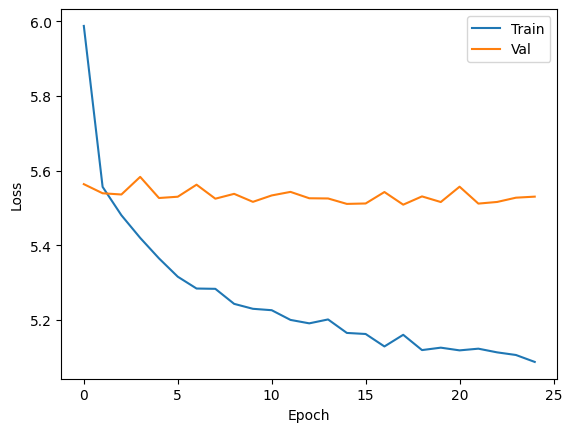

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Inference & Chat

In [ ]:
def predict(model, sentence, word2idx, idx2word, max_len=25, device='cpu'):
    model.eval()

    with torch.no_grad():
        # Encode input sentence
        cleaned = clean_text(sentence)
        input_seq = encode_sentence(cleaned, word2idx, max_len)
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

        # Get encoder outputs (context)
        hidden, cell = model.encoder(input_tensor)

        # Start with <sos> token
        input_token = torch.tensor([word2idx["<sos>"]], dtype=torch.long).to(device)

        result = []
        for _ in range(max_len):
            output, hidden, cell = model.decoder(input_token, hidden, cell)
            top1 = output.argmax(1)
            word_idx = top1.item()
            word = idx2word.get(word_idx, "<unk>")

            if word == "<eos>":
                break
            if word not in ["<pad>", "<sos>", "<unk>"]:
                result.append(word)

            input_token = top1

        return ' '.join(result) if result else "I don't understand."


def chat(model, word2idx, idx2word, device):
    """Interactive chat function"""
    print("\n" + "=" * 60)
    print("Chatbot is ready! Type 'quit' to exit.")
    print("=" * 60 + "\n")

    while True:
        user_input = input("You: ").strip()
        if user_input.lower() in ['quit', 'exit', 'q']:
            print("Goodbye!")
            break
        if not user_input:
            continue

        response = predict(model, user_input, word2idx, idx2word, MAX_LEN, device)
        print(f"Bot: {response}\n")

Test Predictions

In [ ]:
# Load best model
checkpoint = torch.load('best_chatbot_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Test sentences
test_sentences = [
    "Hello, how are you?",
    "What is your name?",
    "Do you love me?",
    "Where are you from?",
    "What do you think about life?",
    "Tell me a joke",
    "I am feeling sad today",
    "What is the meaning of life?"
]

print("\n" + "=" * 60)
print("Sample Predictions:")
print("=" * 60)

for sentence in test_sentences:
    response = predict(model, sentence, word2idx, idx2word, MAX_LEN, device)
    print(f"Input: {sentence}")
    print(f"Response: {response}\n")

Loaded best model from epoch 18

Sample Predictions:
Input: Hello, how are you?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: What is your name?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: Do you love me?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: Where are you from?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: What do you think about life?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: Tell me a joke
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: I am feeling sad today
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: What is the meaning of life?
Response: i , . . . . . . . . . . . . . . . . . . . .



In [ ]:
cleaned = clean_text("hello")
input_seq = encode_sentence(cleaned, word2idx, MAX_LEN)
input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

hidden, cell = model.encoder(input_tensor)
input_token = torch.tensor([word2idx["<sos>"]], dtype=torch.long).to(device)

output, hidden, cell = model.decoder(input_token, hidden, cell)
probs = torch.softmax(output, dim=-1)
topk = torch.topk(probs, 10)
print("Top-10 token indices:", topk.indices.tolist())
print("Top-10 token probs:", topk.values.tolist())
print([idx2word[i] for i in topk.indices.tolist()[0]])

Top-10 token indices: [[133, 122, 39, 4, 14, 653, 93, 153, 104, 376]]
Top-10 token probs: [[0.09363508224487305, 0.044821154326200485, 0.03851831331849098, 0.035744525492191315, 0.023330410942435265, 0.023034755140542984, 0.022640379145741463, 0.02245296910405159, 0.0200455654412508, 0.019092876464128494]]
['i', 'you', 'what', 'no', 'yes', 'oh', "i'm", "it's", 'yeah', 'well']


# Greedy Prediction: Taking argmax and predicting best possible token with highest probability score.

In [63]:
def predict(model, sentence, word2idx, idx2word, max_len=20, device='cpu'):
    model.eval()
    with torch.no_grad():
        input_seq = encode_sentence(clean_text(sentence), word2idx, max_len)
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)
        hidden, cell = model.encoder(input_tensor)
        input_token = torch.tensor([word2idx.get('<sos>', 1)], dtype=torch.long).to(device)
        result = []
        for _ in range(max_len):
            output, hidden, cell = model.decoder(input_token, hidden, cell)
            top1 = output.argmax(1)
            word = idx2word.get(top1.item(), '<unk>')
            if word == '<eos>':
                break
            result.append(word)
            input_token = top1
        return ' '.join(result)

In [65]:
# Load best model
checkpoint = torch.load('best_chatbot_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Test sentences
test_sentences = [
    "loves me or not, yes?",
    "Hello, how are you?",
    "What is your name?",
    "Do you love me?",
    "Where are you from?",
    "What do you think about life?",
    "Tell me a joke",
    "I am feeling sad today",
    "What is the meaning of life?"
]

print("\n" + "=" * 60)
print("Sample Predictions:")
print("=" * 60)

for sentence in test_sentences:
    response = predict(model, sentence, word2idx, idx2word, MAX_LEN, device)
    print(f"Input: {sentence}")
    print(f"Response: {response}\n")

Loaded best model from epoch 18

Sample Predictions:
Input: loves me or not, yes?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: Hello, how are you?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: What is your name?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: Do you love me?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: Where are you from?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: What do you think about life?
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: Tell me a joke
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: I am feeling sad today
Response: i , . . . . . . . . . . . . . . . . . . . .

Input: What is the meaning of life?
Response: i , . . . . . . . . . . . . . . . . . . . .



# Using top K and top P sampling with temprature

to compress and expand the probability distribution to select the next word and using banned token ids so EOS will not be predicted in start and having repetition panalty to encorouge model to generate new tokens.

In [1]:
import torch
import torch.nn.functional as F

# --- Sampling utilities ---
def top_k_top_p_filtering(logits, top_k=0, top_p=1.0, min_tokens_to_keep=1):
    # logits: [vocab_size] (1D)
    logits = logits.clone()

    # Top-k
    if top_k > 0:
        top_k = min(top_k, logits.size(-1))
        kth_vals, kth_idx = torch.topk(logits, top_k)
        min_keep_val = kth_vals[-1]
        logits[logits < min_keep_val] = -float("inf")

    # Nucleus (top-p)
    if 0 < top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        probs = F.softmax(sorted_logits, dim=-1)
        cumprobs = torch.cumsum(probs, dim=-1)

        # Mask tokens where cumulative prob > top_p
        mask = cumprobs > top_p
        # Keep at least min_tokens_to_keep
        if min_tokens_to_keep > 0:
            mask[..., :min_tokens_to_keep] = False
        sorted_logits[mask] = -float("inf")

        # Scatter back to original order
        logits = torch.full_like(logits, -float("inf"))
        logits.scatter_(0, sorted_indices, sorted_logits)

    return logits

def sample_next_token(
    logits,
    temperature=0.8,
    top_k=50,
    top_p=0.9,
    banned_token_ids=None,
    repetition_penalty=1.1,
    generated_ids=None,
):
    # logits: [vocab_size]
    logits = logits.clone()

    # Ban some tokens outright (e.g., <pad>, <sos>)
    if banned_token_ids:
        for tid in banned_token_ids:
            if tid is not None and 0 <= tid < logits.numel():
                logits[tid] = -float("inf")

    # Light repetition penalty for tokens already generated
    if repetition_penalty and repetition_penalty > 1.0 and generated_ids:
        seen = set(generated_ids)
        for tid in seen:
            if 0 <= tid < logits.numel():
                logits[tid] = logits[tid] / repetition_penalty

    # Temperature
    temperature = max(1e-5, float(temperature))
    logits = logits / temperature

    # Filter by top-k / top-p
    logits = top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p, min_tokens_to_keep=1)

    # Convert to probabilities
    probs = F.softmax(logits, dim=-1)

    # If all probs are zero/nan, fall back to argmax
    if not torch.isfinite(probs).all() or probs.sum() <= 0:
        return torch.argmax(logits, dim=-1, keepdim=True)

    # Sample
    next_token = torch.multinomial(probs, num_samples=1)  # shape [1]
    return next_token

In [68]:
def predict(
    model,
    sentence,
    word2idx,
    idx2word,
    max_len=25,
    device=None,
    temperature=0.8,
    top_k=50,
    top_p=0.9,
    min_len=3,
    repetition_penalty=1.15,
):
    """
    Decodes with temperature + top-k/top-p sampling.
    - Keeps <unk> (only drops <pad> and <sos> from the final string).
    - Avoids early <eos> until min_len.
    - Avoids repeating punctuation back-to-back.
    """
    model.eval()

    # Resolve device automatically if not provided
    if device is None:
        device = next(model.parameters()).device

    # Special token ids
    pad_id = word2idx.get("<pad>", 0)
    sos_id = word2idx.get("<sos>")
    eos_id = word2idx.get("<eos>")
    unk_id = word2idx.get("<unk>")

    # Punctuation ids (to avoid repeating the same punctuation)
    punct_ids = [word2idx[t] for t in [",", ".", "!", "?", "¿"] if t in word2idx]

    with torch.no_grad():
        # Encode input
        cleaned = clean_text(sentence)
        input_seq = encode_sentence(cleaned, word2idx, max_len)
        input_tensor = torch.tensor(input_seq, dtype=torch.long).unsqueeze(0).to(device)

        # Encode
        hidden, cell = model.encoder(input_tensor)

        # Start token
        if sos_id is None:
            # fallback if vocab didn’t include <sos>
            sos_id = unk_id if unk_id is not None else 1
        input_token = torch.tensor([sos_id], dtype=torch.long).to(device)

        generated_ids = []
        result_tokens = []

        for t in range(max_len):
            output, hidden, cell = model.decoder(input_token, hidden, cell)
            # output: [batch=1, vocab_size]
            logits = output.squeeze(0)  # [vocab_size]

            # Ban base tokens each step
            banned = {pad_id, sos_id}
            # Avoid consecutive duplicate punctuation (e.g., ", , ,")
            if len(generated_ids) > 0 and generated_ids[-1] in punct_ids:
                banned.add(generated_ids[-1])

            # Avoid early EOS
            if eos_id is not None and t < min_len:
                banned.add(eos_id)

            # Sample next token
            next_token = sample_next_token(
                logits,
                temperature=temperature,
                top_k=top_k,
                top_p=top_p,
                banned_token_ids=banned,
                repetition_penalty=repetition_penalty,
                generated_ids=generated_ids,
            )
            token_id = int(next_token.item())
            generated_ids.append(token_id)

            # Stop if EOS (after min_len)
            if eos_id is not None and token_id == eos_id and t >= min_len:
                break

            # Convert to word; keep <unk> to avoid “disappearing” content
            word = idx2word.get(token_id, "<unk>")
            if word not in ["<pad>", "<sos>"]:
                result_tokens.append(word)

            input_token = next_token  # feed next

        # Simple detokenization: remove space before punctuation
        text = " ".join(result_tokens)
        text = (
            text.replace(" ,", ",")
                .replace(" .", ".")
                .replace(" !", "!")
                .replace(" ?", "?")
                .replace(" ’ ", "’")
        )
        return text if text.strip() else "I don't understand."

In [80]:
# After loading checkpoint:
checkpoint = torch.load('best_chatbot_model.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# Try different temperatures / top-k / top-p if needed
tests = [
    "Hello, how are you?",
    "What is your name?",
    "Tell me a joke.",
    "I am feeling sad today.",
    "Where are you from?",
    "What do you think about life?",
    "loves me or not, yes?",
    "how are you."
]

for s in tests:
    print("You:", s)
    print("Bot:", predict(model, s, word2idx, idx2word, MAX_LEN, device,
                          temperature=0.8, top_k=50, top_p=0.9))
    print()

You: Hello, how are you?
Bot: i?, i, you know. <unk> on your life.

You: What is your name?
Bot: you mean, i.

You: Tell me a joke.
Bot: no,.

You: I am feeling sad today.
Bot: . for your way?

You: Where are you from?
Bot: yes, then you, mr., i'm a here. it, but you're a that i need it <unk>!

You: What do you think about life?
Bot: you're a, you just go.

You: loves me or not, yes?
Bot: okay, but.?

You: how are you.
Bot: we can have you that, but i do. i would just be me to see my whole.

